In [1]:
import numpy as np
import cv2
from tqdm import tqdm_notebook
import os, os.path
import matplotlib.pyplot as plt

In [2]:
datasets = ['Biker', 'football']
# points with template roi. I get them from dataset file
roi_s = {
    'football': ((300,100),(60,60)),
    'Biker': ((262, 94), (16, 26)),
}

In [3]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
   qualityLevel = 0.3,
   minDistance = 1,
   blockSize = 7 )
# Parameters for lucas kanade
calcOpticalFlowPyrLKParams = dict(
    winSize  = (15,15),
    maxLevel = 2,
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [16]:
def makeVideo(images, name):
    from matplotlib import animation, rc

    # below code for video saving..
    fig = plt.figure()
    video_img = [[plt.imshow(img, cmap='gray')] for img in images]
    # ATTENTION: may need some changes here to work locally.
    # for mac suer run: $ brew install ffmpeg
    plt.rcParams['animation.ffmpeg_path'] = u'/usr/local/bin/ffmpeg'
    ani = animation.ArtistAnimation(fig, video_img, interval=500, blit=True, repeat_delay=1000)
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(name, writer=writer)
    plt.clf()

Dataset Biker loaded!


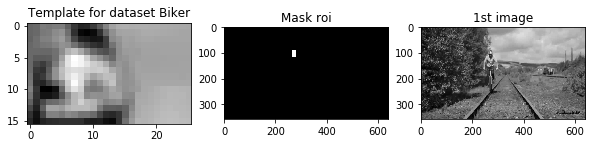

Dataset football loaded!


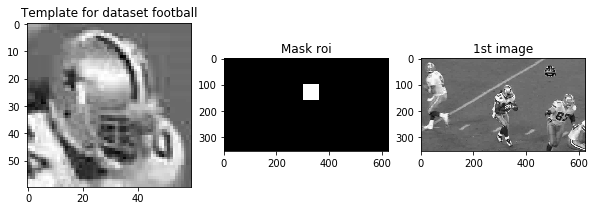

In [26]:
for dataset in datasets:
    img_l = len([name for name in os.listdir(f'./datasets/{dataset}/img')])
    images = [cv2.imread(f"./datasets/{dataset}/img/{str(i).zfill(4)}.jpg", 0) for i in range(1,img_l+1)]
    print(f"Dataset {dataset} loaded!")
    
    # set up starting target points
    (roi_x, roi_y), (w, h) = roi_s[dataset]
    # get first image from images
    prev, *images = images
    
    fig, axes = plt.subplots(1,3)
    fig.set_size_inches((10,15))
    # display 1st target zone which is template we track
    template = prev[roi_y:roi_y+w, roi_x: roi_x + h]
    axes[0].set_title(f"Template for dataset {dataset}")
    axes[0].imshow(template, cmap='gray')
    
    # store image sizes
    im_h, im_w = prev.shape

    # define the mask
    mask_roi = np.zeros_like(prev)
    # fill the template zone with ones
    mask_roi[roi_y:roi_y+h, roi_x:roi_x+w] = 1
    
    axes[1].set_title("Mask roi")
    axes[1].imshow(mask_roi, cmap='gray')
    
    axes[2].set_title("1st image")
    axes[2].imshow(prev, cmap='gray')
    plt.show()
    
    prev_points = cv2.goodFeaturesToTrack(prev, mask = mask_roi, **feature_params)
    image_results = []

    for img in tqdm_notebook(images, desc=f"Processing {dataset}.."):
        current_point, st, err = cv2.calcOpticalFlowPyrLK(prev, img, prev_points, None, **calcOpticalFlowPyrLKParams)
    
        new_points = current_point[st==1]
        old_points = prev_points[st==1]
    
        # get coordinates changes
        deltas = new_points-old_points
        deltas = deltas.mean(axis=0)
        deltas = np.round(deltas)

        dx, dy = deltas
        dx, dy = int(dx), int(dy)
        # set new roi coordinates
        roi_new_x, roi_new_y = roi_x + dx, roi_y + dy

        # update old points with current values
        roi_x, roi_y = roi_new_x, roi_new_y
        prev_points = new_points.reshape(-1,1,2)
        prev = img.copy()
        
        # draw rectangle and add new image to the video array
        result = img.copy()
        result = cv2.rectangle(result, (roi_new_x, roi_new_y), (roi_new_x + w, roi_new_y + h), 255, 3)
        image_results.append(result)
    # save video
    makeVideo(image_results, f"results/lucas_canade_{dataset}.mp4")

From video generated we can see that the results are much better then from template matching. But there are still problems when football player run close to the group of teamates and tracker loose our player.

With biker example tracker can not recognize that head is increasing(biker is approaching). Also when biker turns aroud tracker loose face but still attach to biker body.